In [3]:
'''Implements Q-learning for a continuous state space using a feed-forward neural network to approximate Q'''


import gym
import gym_minigrid
import logging
import numpy as np
from collections import defaultdict
from lib import plotting
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from scipy.stats import entropy


In [4]:
ENV_NAME = 'CartPole-v0'
env = gym.make(ENV_NAME)
#env = gym.wrappers.Monitor(env, 'tmp/training-dir/')
logger = logging.getLogger()
logger.setLevel(logging.INFO)
%matplotlib inline


In [5]:
class FeedForwardNetwork(nn.Module):
    ''' Simple feed-forward NN for approximating the Q-function
    1 hidden layer'''
    def __init__(self, input_dim, hidden_dim, output_dim):
        nn.Module.__init__(self)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)


    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))


In [6]:
def select_action(model, observation, *, num_actions, epsilon):
    '''Select an action using the e-greedy policy based on the model

    :param model: torch.nn model
    :param observation: observation from the environment to select the action for
    :param num_actions: Size of action space
    :param epsilon: Probability of taking a random action
    :returns: an action from [0, num_actions)
    :rtype: Int
    '''
    if np.random.uniform() < epsilon:
        return np.random.choice(num_actions)
    else:
        return model(torch.Tensor(observation)).argmax().item()


def q_learning(env, model, optimizer, *, num_episodes, alpha, gamma, epsilon, max_entropy):
    """Run Q-learning (with neural network function approximator)

    :param env: OpenAI environment
    :param model: torch.nn model
    :param optimizer: torch.optim optimizer
    :param num_episodes: Number of episodes to run
    :param alpha: Learning rate
    :param gamma: Discount factor
    :param epsilon: Probability of taking a random action
    :param max_entropy: Boolean indicating inclusion/exclusion of entropy bonus
    :returns: Statistics
    :rtype: plotting.EpisodeStats

    """
    statistics = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))
    nA = env.action_space.n
    q = defaultdict(lambda: np.zeros(nA))
    for episode_idx in range(num_episodes):
        if (episode_idx + 1) % 10 == 0:
            print("\nEpisode {}/{}"
                  .format(episode_idx + 1, num_episodes))
        observation = env.reset()
        terminal = False
        t = 1
        while not terminal:
            action = select_action(model, observation, num_actions=nA, epsilon=epsilon)
            next_observation, reward, done, _ = env.step(action)
            statistics.episode_rewards[episode_idx] += reward
            statistics.episode_lengths[episode_idx] = t
            prediction_distribution = model(torch.Tensor(observation))
            prediction = prediction_distribution[action]
            if max_entropy:
                entropy_bonus = entropy(prediction_distribution.data)
                # not sure if bonus should go in target or prediction
                target = reward + gamma * model(torch.Tensor(next_observation)).max() + entropy_bonus
            else:
                target = reward + gamma * model(torch.Tensor(next_observation)).max()
            loss = nn.functional.mse_loss(prediction, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if done:
                terminal = True
            else:
                observation = next_observation
                t += 1
    return statistics


  0%|                                                                                                                                                                                                                                                                                                 | 0/1 [00:00<?, ?it/s]


Episode 10/100

Episode 20/100

Episode 30/100

Episode 40/100

Episode 50/100

Episode 60/100

Episode 70/100

Episode 80/100

Episode 90/100

Episode 100/100


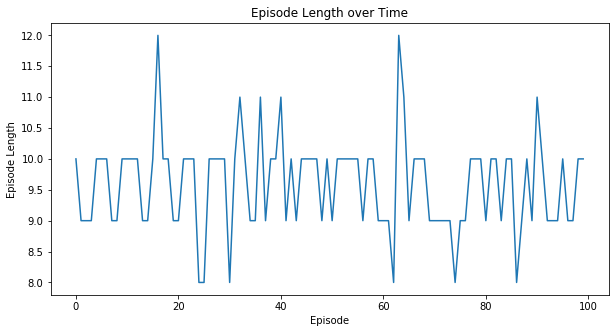

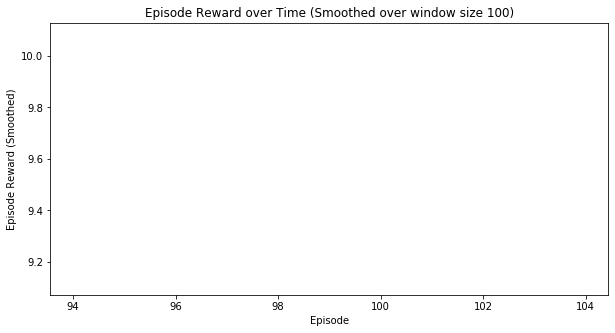

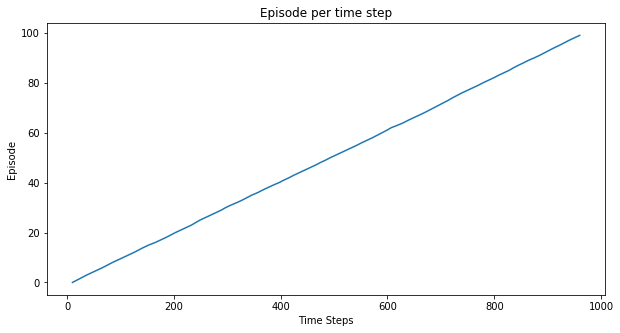

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]


In [7]:
NUM_RUNS = 1
NUM_EPISODES = 100
INPUT_DIM = 4
HIDDEN_DIM = 3
OUTPUT_DIM = 2
LEARNING_RATE = 1e-4
model = FeedForwardNetwork(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
for run_idx in tqdm(range(NUM_RUNS)):
    run_stats = q_learning(env, model, optimizer, num_episodes=NUM_EPISODES, alpha=.1, gamma=1, epsilon=.05, max_entropy=False)
    plotting.plot_episode_stats(run_stats)